In [48]:
import os
import sys
sys.path.append(os.path.abspath("../"))

import tensorflow as tf
import matplotlib.pyplot as plt
import mlflow

from models_src.Support import DatasetGenerator
from models_src.UNet_model import UNet
from models_src.Metrics import WeightedF12D

%matplotlib inline

# Edge detection model

## load model

In [2]:
run_name = 'gentle-kit'

In [4]:
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/fzzyfoxx@gmail.com/GeoDoc-edge-detection")
run_args = mlflow.search_runs(filter_string=f"tags.mlflow.runName like '{run_name}%'").iloc[0]
mlflow.artifacts.download_artifacts(run_id=run_args.run_id,artifact_path='final_state',
                                    dst_path=f'./{run_name}')
            

'/home/fzzyfoxx/projects/GeoDoc/maps_vectorization/Vertex_detection/gentle-kit/final_state'

In [5]:
unet_args = {
    'init_filters_power': 4,
    'levels': 4,
    'init_dropout': 0.0,
    'dropout': 0.25,
    'level_convs': 3,
    'color_embeddings': False,
    'input_shape': (256, 256, 3),
    'out_activation': 'sigmoid',
    'out_dims': 1,
    'batch_normalization': True
    }

edge_detector = UNet(**unet_args)
edge_detector.load_weights(f'./{run_name}/final_state/variables')

In [35]:
class cfg:
    ds_batch_size = 1
    target_size = 256
    parcel_input_batch_size = 128
    max_vertices_num = 50
    max_shapes_num = 10
    add_legend = 0
    add_minimap = 0
    output_type = 2
    fold_size = 128
    num_parallel_calls = 4
    test_mode = 1
    parcel_input_adjustment = True
    n_clusters=30

In [7]:
dataset_name = 'edges_2types'

In [36]:
dg = DatasetGenerator(cfg, None)
dg.new_dataset(from_saved=True, ds_path=f'../datasets/{dataset_name}', validation=True, val_idxs=[0], shuffle_buffer_size=0, fold_size=128)
dg.new_dataset(from_saved=True, ds_path=f'../datasets/{dataset_name}', validation=False, val_idxs=[0], shuffle_buffer_size=0, fold_size=128)


Generate new dataset

Generate new dataset


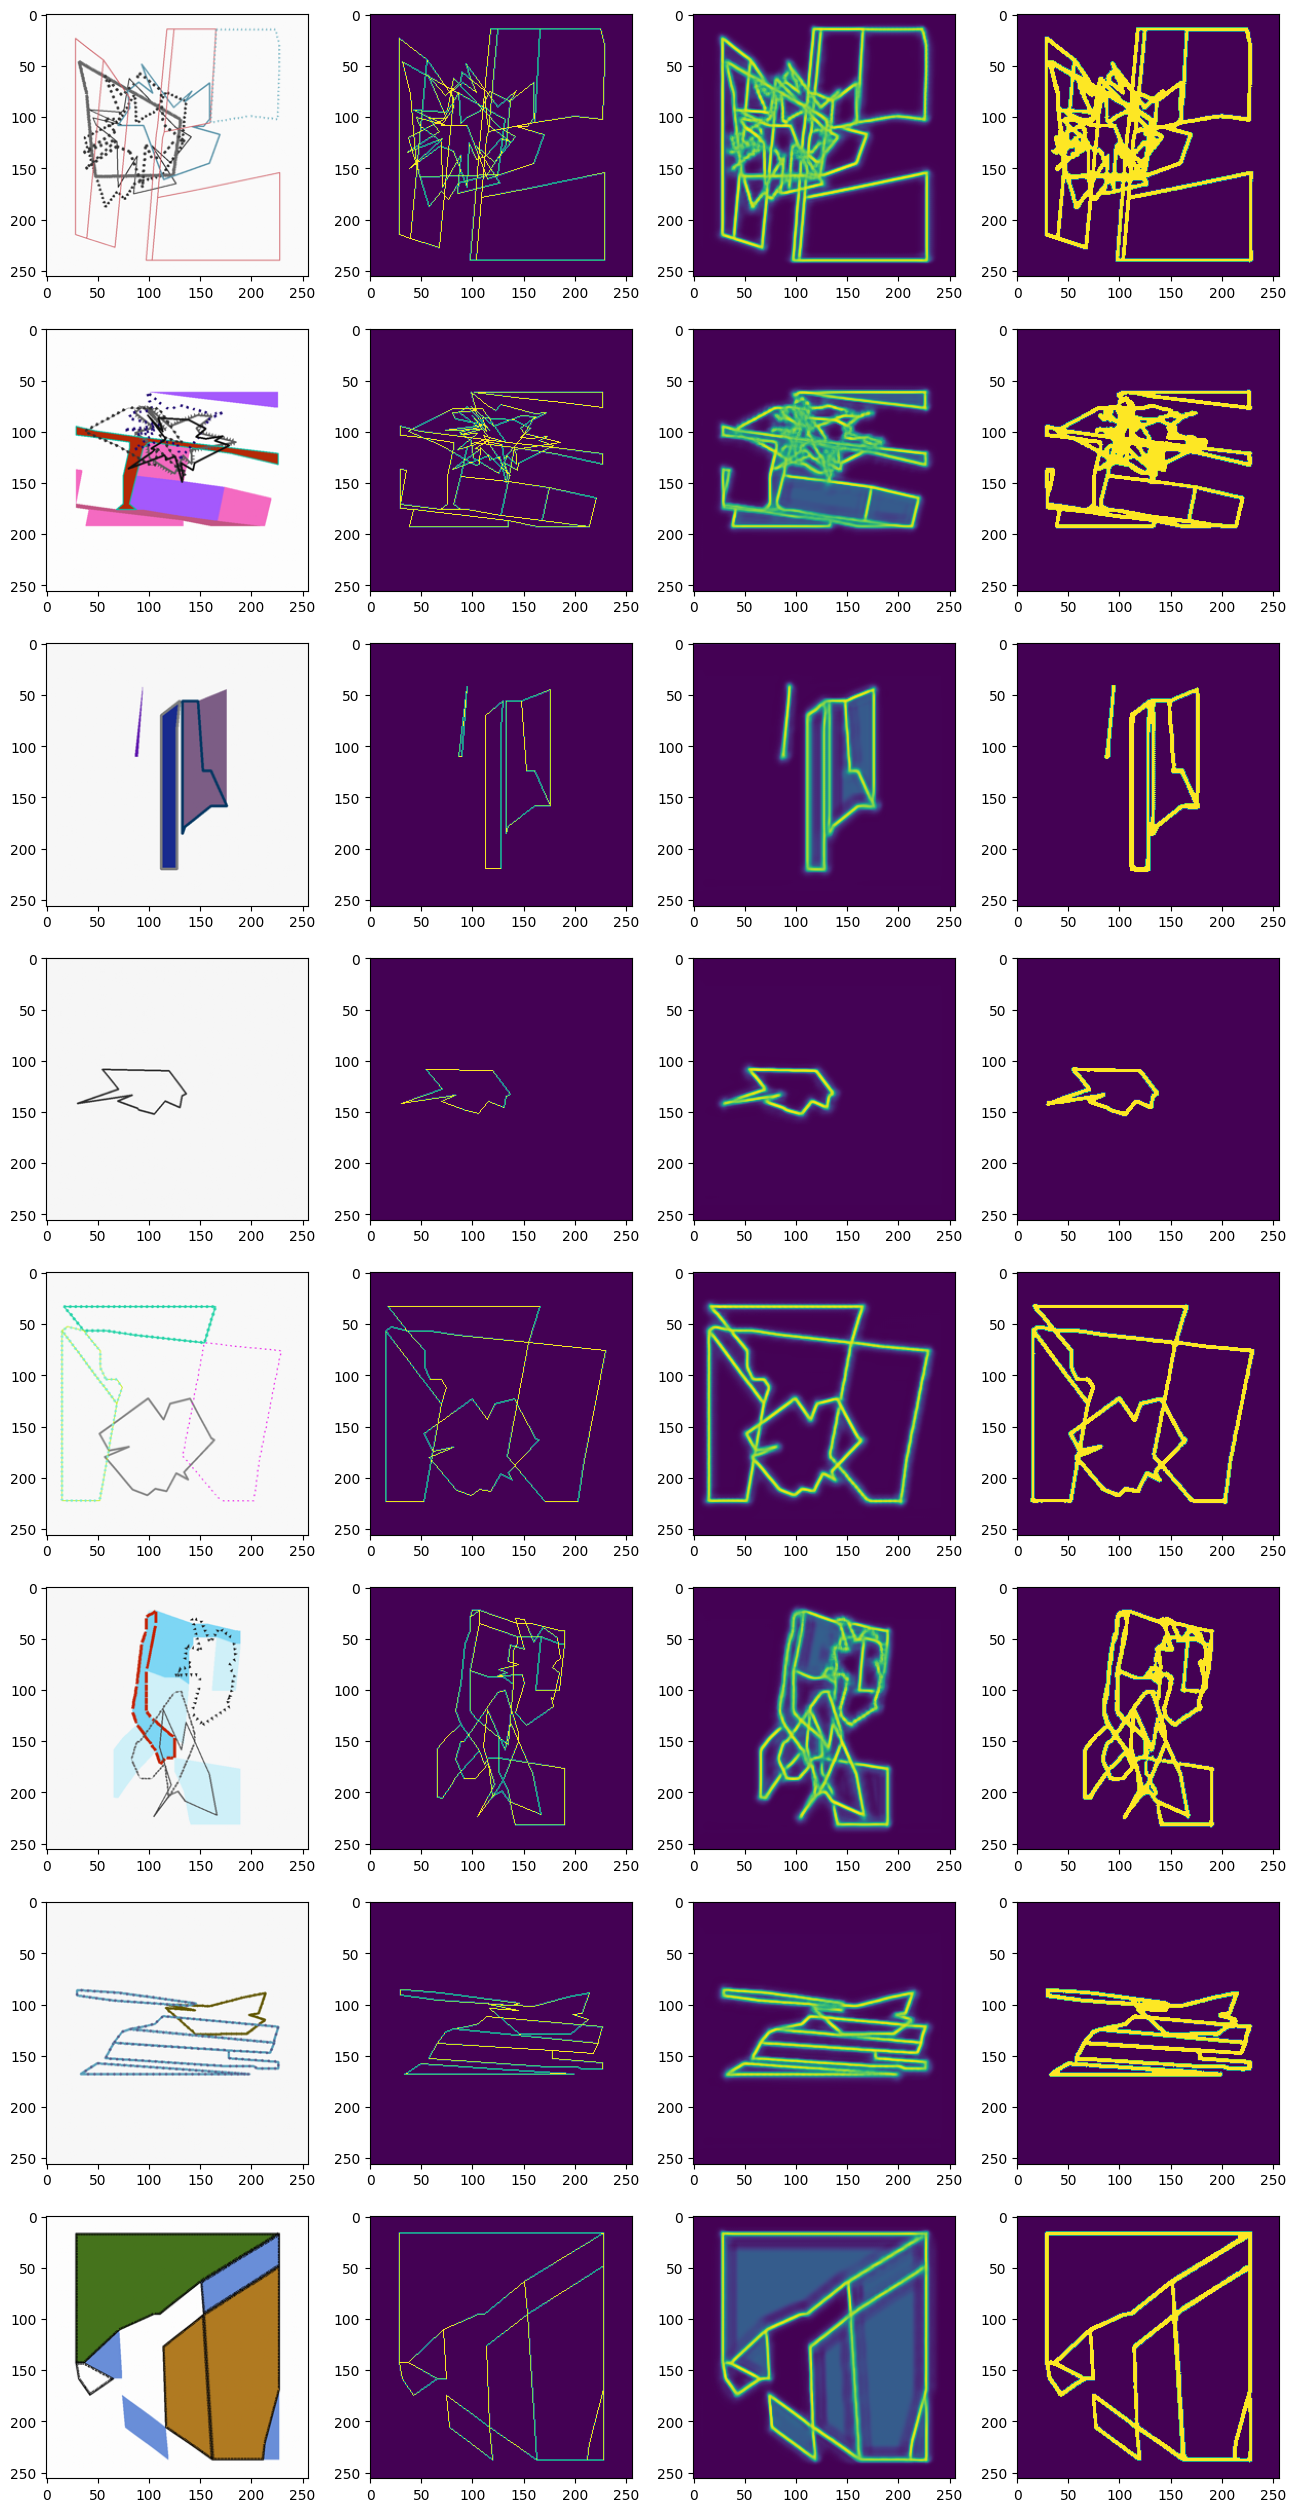

In [18]:
features, labels = next(dg.val_iter)
preds = edge_detector(features, training=False)

s = 8
fig, axs = plt.subplots(s,4, figsize=(4*4,s*4))
for i in range(s):
    axs[i,0].imshow(features[i])
    axs[i,1].imshow(labels[i], cmap='viridis', alpha=1.0)
    axs[i,2].imshow(preds[i], cmap='viridis', alpha=1.0)
    axs[i,3].imshow(tf.where(preds[i]>0.5, 1.0, 0.0), cmap='viridis', alpha=1.0)

## CRF implementation

In [29]:
from models_src.CRF.src.crfrnn_layer import CrfRnnLayer

In [87]:
def add_crf_layer(original_model, num_classes=1, theta_alpha=3, theta_beta=160., theta_gamma=3., num_iterations=10, name='CFRnn'):
    original_model.trainable = False
    inputs = original_model.inputs
    x = original_model.outputs[0]
    x = tf.concat([x,1-x], axis=-1)
    H,W = original_model.output_shape[1], original_model.output_shape[2]
    crf_layer = CrfRnnLayer(image_dims=(H, W),
                            num_classes=num_classes,
                            theta_alpha=theta_alpha,
                            theta_beta=theta_beta,
                            theta_gamma=theta_gamma,
                            num_iterations=num_iterations,
                            name=name)([x, original_model.inputs[0]])

    new_crf_model = tf.keras.Model(inputs = inputs, outputs = crf_layer)

    return(new_crf_model)

In [82]:
class cfg:
    ds_batch_size = 1
    target_size = 256
    parcel_input_batch_size = 128
    max_vertices_num = 50
    max_shapes_num = 10
    add_legend = 0
    add_minimap = 0
    output_type = 2
    fold_size = 128
    num_parallel_calls = 4
    test_mode = 1
    parcel_input_adjustment = True
    n_clusters=30

dg = DatasetGenerator(cfg, None)
dg.new_dataset(from_saved=True, ds_path=f'../datasets/{dataset_name}', validation=True, val_idxs=[0], shuffle_buffer_size=0, fold_size=128)
dg.new_dataset(from_saved=True, ds_path=f'../datasets/{dataset_name}', validation=False, val_idxs=[0], shuffle_buffer_size=0, fold_size=128)

dg.ds = dg.ds.map(lambda *x: (x[0], tf.concat([x[1],1-x[1]], axis=-1)))
dg.val_ds = dg.val_ds.map(lambda *x: (x[0], tf.concat([x[1],1-x[1]], axis=-1)))
dg.ds_iter = iter(dg.ds)
dg.val_iter = iter(dg.val_ds)


Generate new dataset

Generate new dataset


In [94]:
edge_detector_crf = add_crf_layer(edge_detector, num_classes=2, theta_alpha=3, theta_beta=160., theta_gamma=10., num_iterations=10)
edge_detector_crf.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 unet_input (InputLayer)     [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Batch-Normalization (Batch  (None, 256, 256, 3)          12        ['unet_input[0][0]']          
 Normalization)                                                                                   
                                                                                                  
 Down-Conv_1 (UNetConvBlock  ((None, 128, 128, 16),       5088      ['Batch-Normalization[0][0]'] 
 )                            (None, 256, 256, 16))                                               
                                                                                           

In [95]:
edge_detector_crf.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.75, gamma=2),
    metrics = [
        tf.keras.metrics.Precision(name='Prec'),
        tf.keras.metrics.Recall(name='Rec'),
        WeightedF12D(threshold=0.5)
    ]
)

In [96]:
edge_detector_crf.fit(
    dg.ds, 
    validation_data=dg.val_ds,
    validation_steps=dg.val_steps,
    validation_freq=1,
    epochs=1, 
    steps_per_epoch=dg.train_steps, 
    )

2560/2560 [==============================] - 1071s 418ms/step - loss: 0.0566 - Prec: 0.9176 - Rec: 0.9989 - F1: 0.9503 - val_loss: 0.0118 - val_Prec: 0.9180 - val_Rec: 0.9987 - val_F1: 0.9563


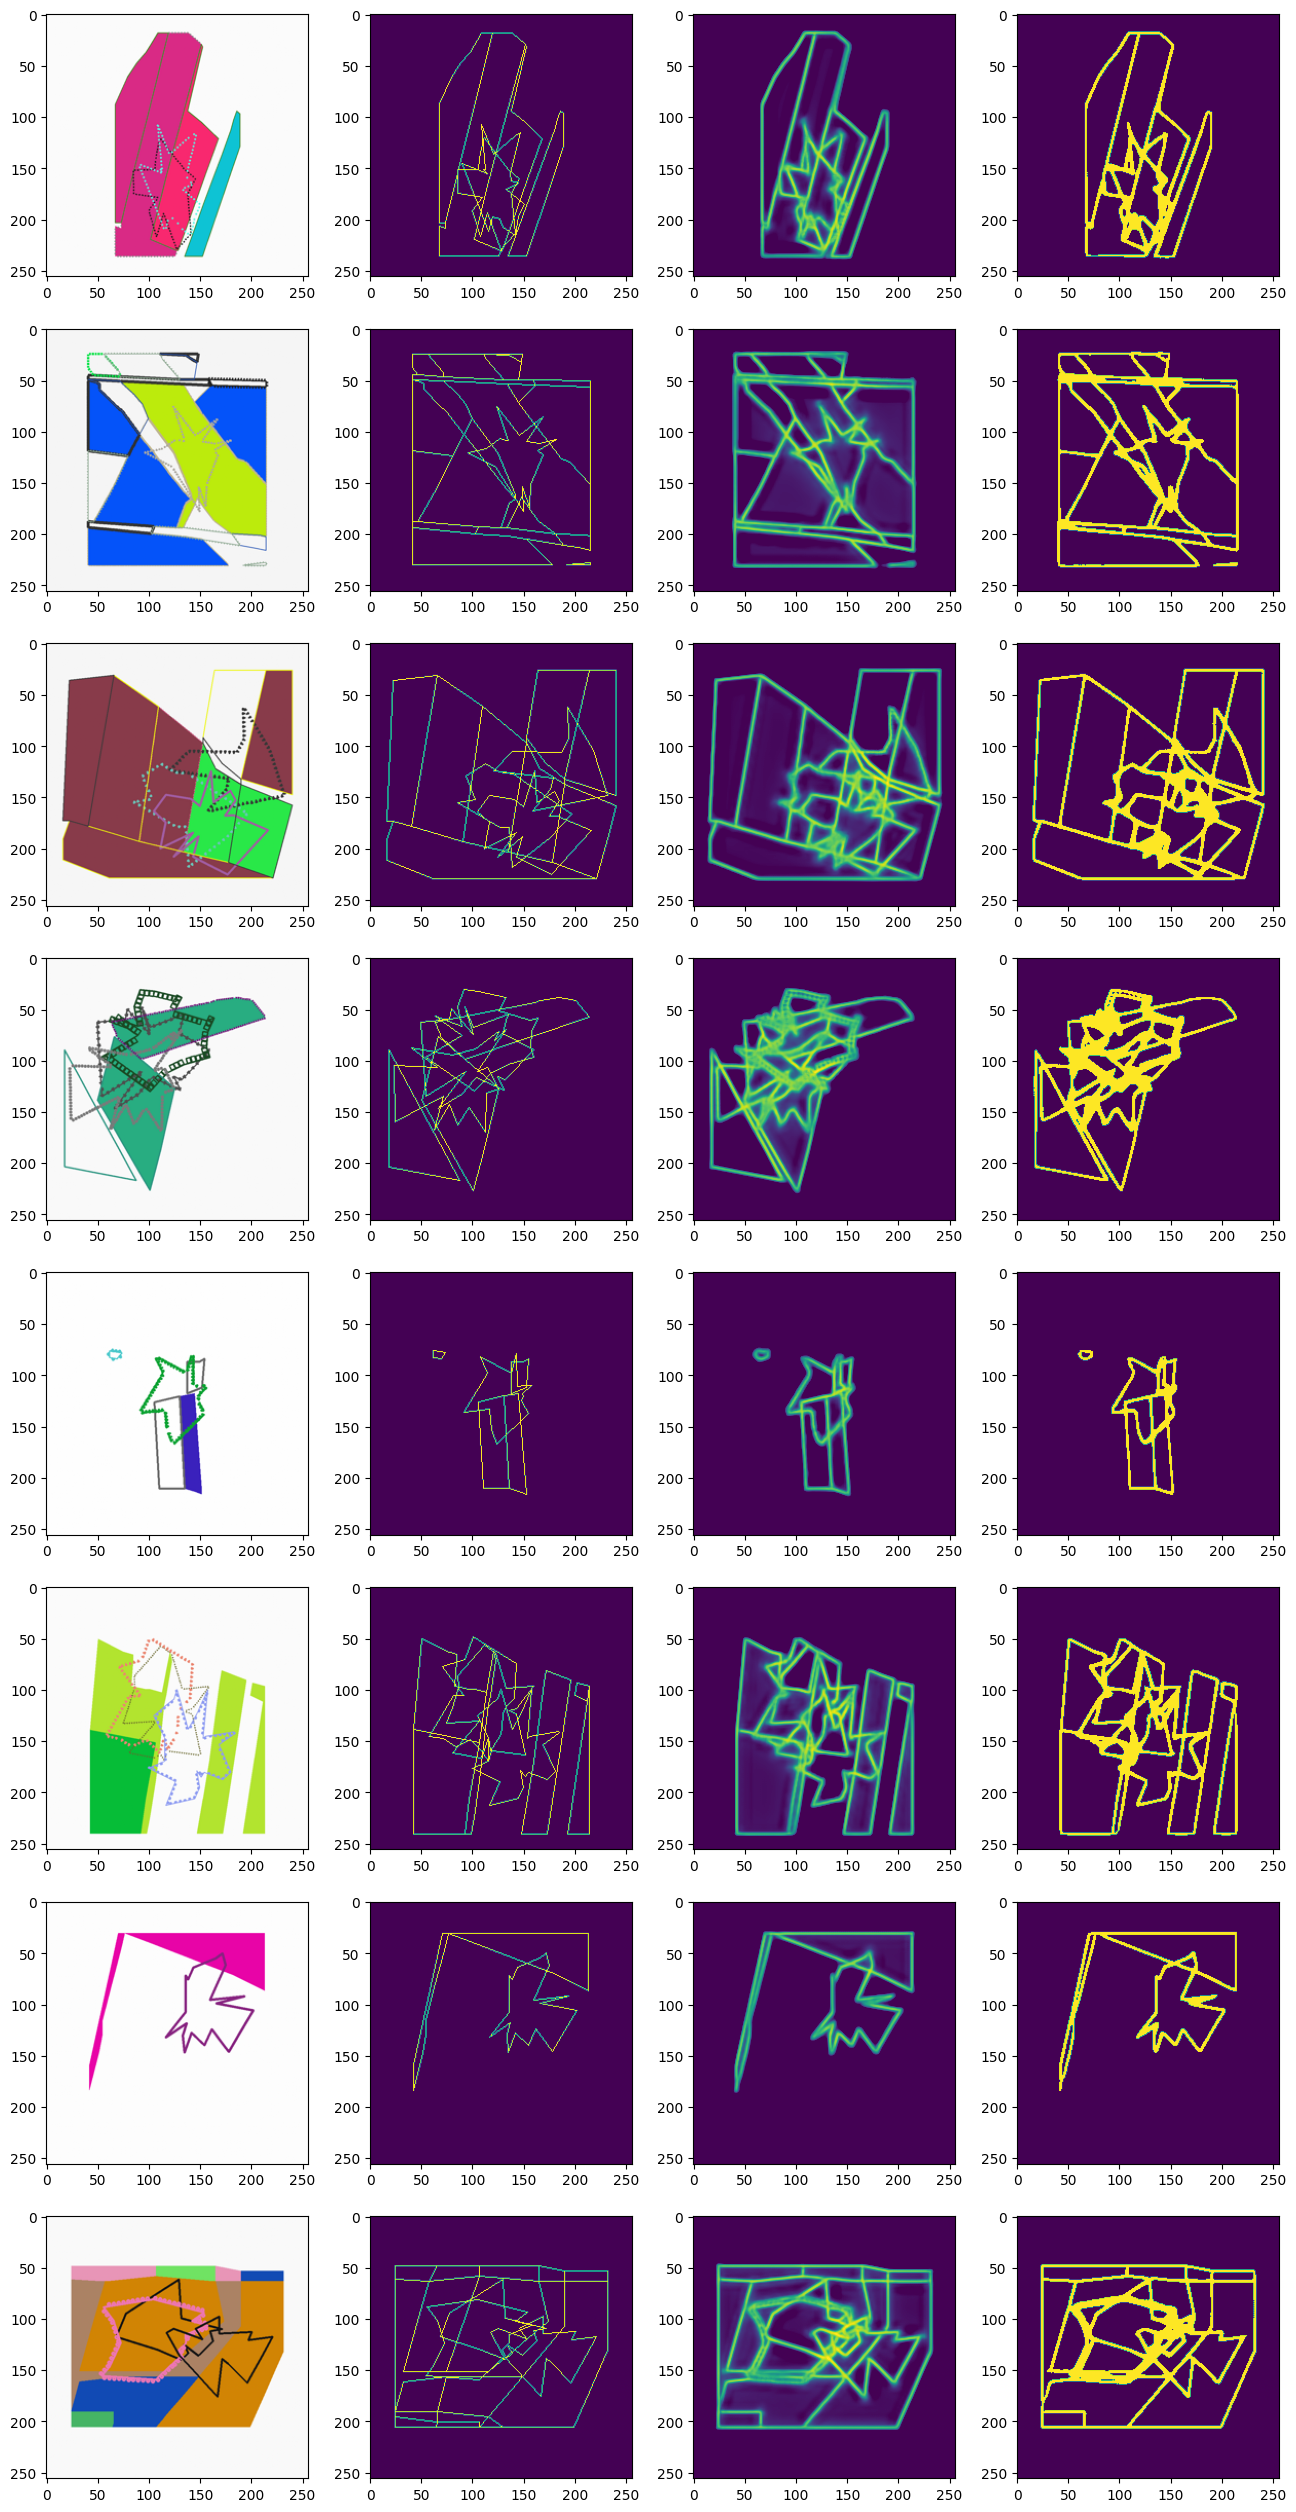

In [97]:
s = 8
preds = []
features = []
labels = []

for i in range(s):
    single_feature, single_label = next(dg.val_iter)
    single_pred = edge_detector_crf(single_feature, training=False)[...,:1]
    preds.append(single_pred)
    features.append(single_feature)
    labels.append(single_label[...,:1])

fig, axs = plt.subplots(s,4, figsize=(4*4,s*4))
for i in range(s):
    axs[i,0].imshow(features[i][0])
    axs[i,1].imshow(labels[i][0], cmap='viridis', alpha=1.0)
    axs[i,2].imshow(preds[i][0], cmap='viridis', alpha=1.0, vmin=0, vmax=1)
    axs[i,3].imshow(tf.where(preds[i][0]>0.5, 1.0, 0.0), cmap='viridis', alpha=1.0, vmin=0, vmax=1)